# Save reconstructed data

Here, I will reconstruct the MNIST dataset from the encoded MNIST dataset using the CNN with one convolutional layer and sigmoid activation function. The intent is to use the reconstructed images to train a classification network and evaluate the performance against the straight classification model. 

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision.transforms as transforms
from torchvision import datasets
import torch
import torch.nn.utils as utils
import sklearn
import wandb

desktop_path = '/Users/jocelynornelasmunoz/Desktop/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

import MURA as mura
from Reconstruct import CNN
import confusion_matrix as cm
import wandb_functions as wf

Using path =  /Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/


In [7]:
# Update plotting parameters
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [15,7],#[15,10],
})

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
wandb.login()

Using cpu device


True

# Prepare MNIST Data

## Hyperparameters
Here, I will define hyperparameters for both the model and some needed for preprocessing.  

To define the MURA encoding and decoding, we first define a size $p$ for the MURA array and then use the encoder and decoding functions to create the encoder array $A$ and the decoder array $G$

In [9]:
%%time
# define hyperparameters
params = {
  "dataset": "encoded_MNIST",
  "learning_rate": 1e-3,
  "batch_size": 100,
  "epochs": 50,
  "kernel_size":23,
  "p": 23, # size of array (has to be prime)
  "image_size": 23,
  "kind": "recon",
  "suffix": "activation",
  "lambda": 0,
}
params['model'] = params['kind']+'_' + params['suffix'] 
if params['lambda'] != 0:
    params['model'] = params['model'] + f"{params['lambda']:.0e}" 

# Compute MURA encoder and decoder
params['A'] = mura.create_binary_aperture_arr(params['p'])
params['G'] = mura.create_decoding_arr(params['A'])
wandb.config = wf.wandb_config(params)

CPU times: user 1.97 ms, sys: 87 µs, total: 2.06 ms
Wall time: 2.04 ms


# Load data

In [10]:
%%time
mura_train_data, mura_eval_data, mura_test_data, loaders = CNN.load_data(params)

Number of elements in each dataset 
Training: 56000 
Validation: 7000 
Testing: 7000
CPU times: user 6.94 s, sys: 3.1 s, total: 10 s
Wall time: 17.7 s


# Define Model

In [11]:
# Instantiate model 
model = CNN(params)#.to(device)
model.optimizer = torch.optim.Adam(model.parameters(), lr = model.params['learning_rate']) 

Using the following parameters:
dataset: encoded_MNIST
learning_rate: 0.001
batch_size: 100
epochs: 50
kernel_size: 23
p: 23
image_size: 23
kind: recon
suffix: activation
lambda: 0
model: recon_activation
A: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.]


Initial weights Shape: torch.Size([1, 1, 23, 23])


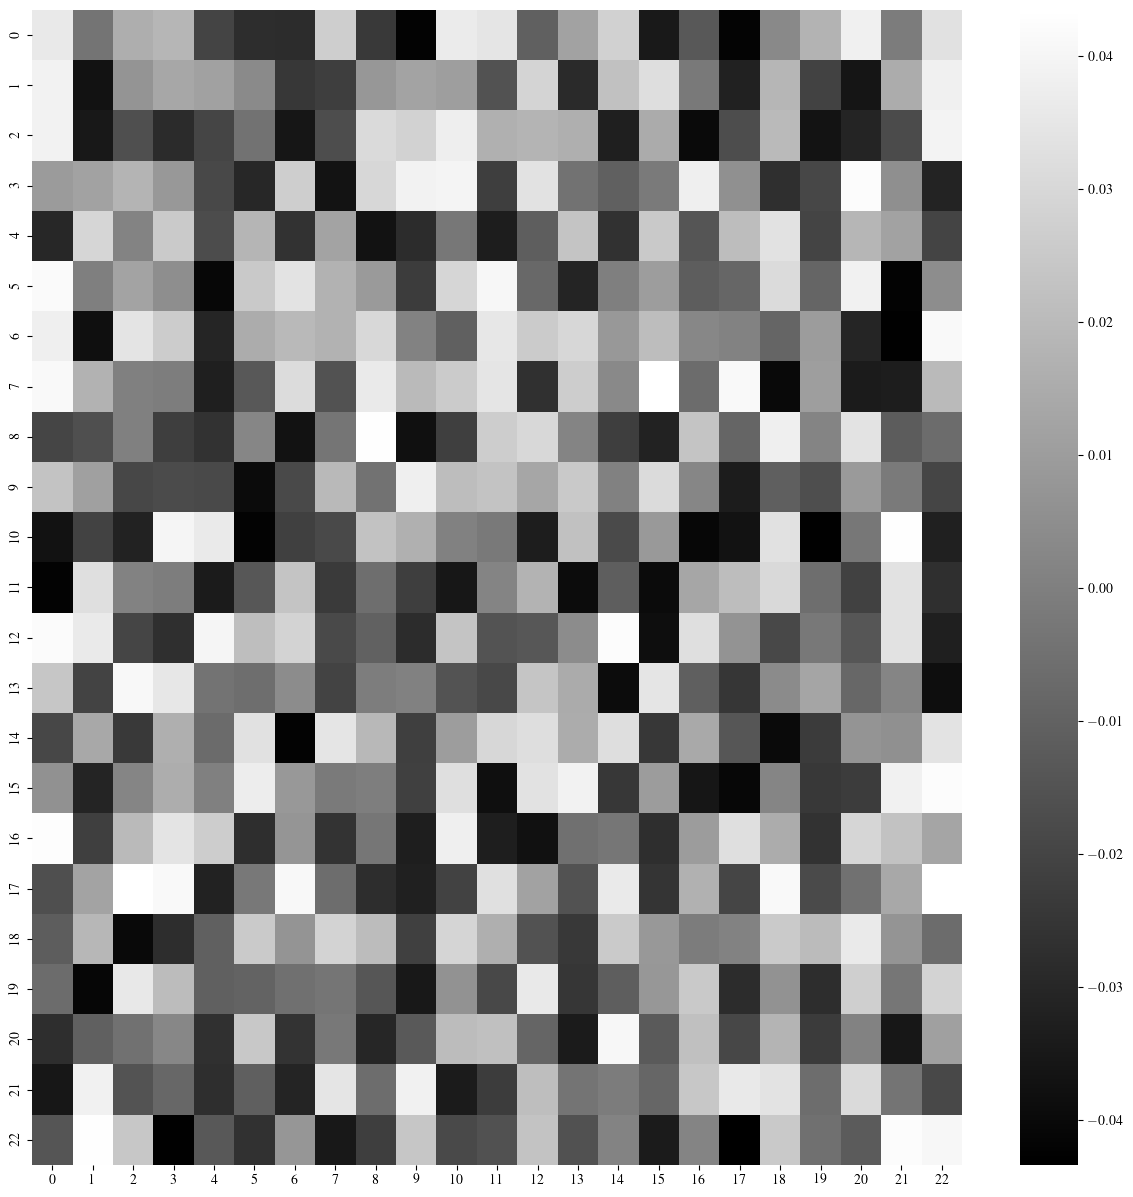

Target weights shape: (23, 23)


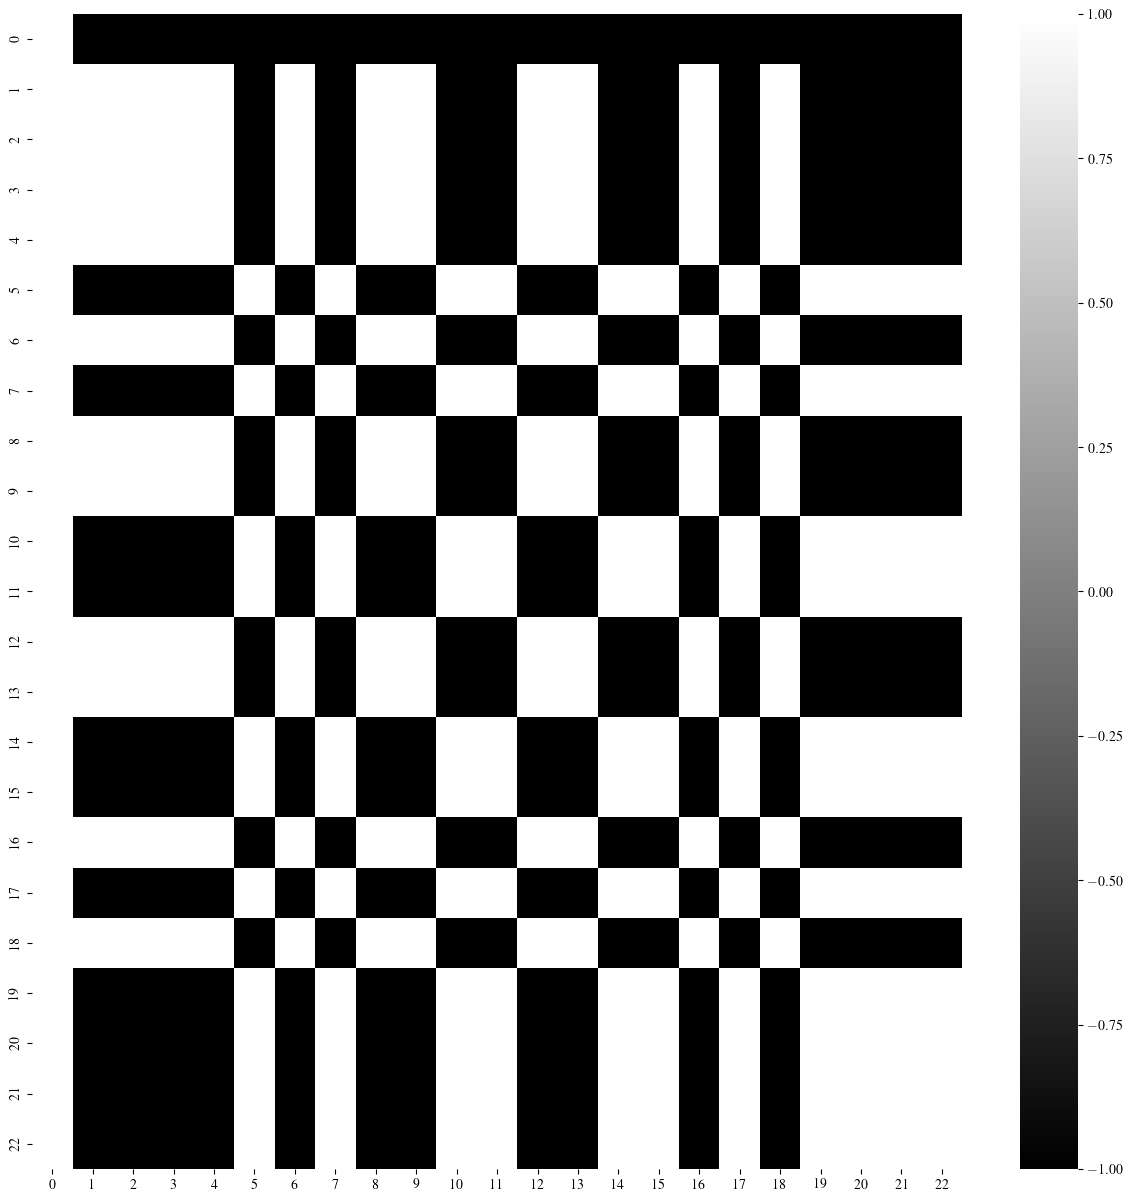

In [10]:
# ----------- Plot initial weights and target weights---- 
# From Jacky's SAR stuff
# Define initial weights from the CNN model
init_weights = list(model.parameters())
init_weight_map = init_weights[0].detach()
print('Initial weights Shape: {}'.format(init_weights[0].shape))

# Plot initial weights
plt.figure(figsize=(15,15))
heat = sns.heatmap(np.squeeze(init_weight_map.cpu().numpy()), cmap='gray')
figure = heat.get_figure()
#figure.savefig(folder_name+'/metrics/heat_init.png',bbox='tight',dpi=400)
#plt.close()
plt.show()

# Define and plot target weights
target_weights = model.params['G']
print('Target weights shape: {}'.format(target_weights.shape))
plt.figure(figsize=(15,15))
heat = sns.heatmap(target_weights, cmap='gray')
figure = heat.get_figure()
#figure.savefig(folder_name+'/metrics/heat_target.png',bbox='tight',dpi=400)
#plt.close()
plt.show()

# Evaluation

In [12]:
# Load model if one is not loaded already
PATH = model.params['model_save_path']
model.load_state_dict(torch.load(PATH))
# Print out the keys save in the state dictionary
for key in list(model.state_dict().keys()):
    print(key)

conv.weight
conv.bias


# Code for validation set evaluation

In [22]:
# Initialize variables
images_all = []
predicted_all = []
labels_all = []
digit_labels_all = []
mse_all = []
test_outputs = {}
recon_train = []
recon_eval = []
recon_test = []

with torch.no_grad():

    # Evaluate training set
    for data in loaders['train']:
        # get images and labels from test set
        img_batch, label_batch, digit_batch = data
        
        # calculate outputs by running images through the network (done in batches)
        pred_batch = model(img_batch)
        
        # Calculate MSE for each pair of label,prediction images
        for image, label, prediction, digit in zip(img_batch, label_batch, pred_batch, digit_batch):
            recon_train.append(tuple([image, label, prediction, digit]))
    
    # Evaluate validation set
    for data in loaders['eval']:
        # get images and labels from test set
        img_batch, label_batch, digit_batch = data
        
        # calculate outputs by running images through the network (done in batches)
        pred_batch = model(img_batch)
        
        # Calculate MSE for each pair of label,prediction images
        for image, label, prediction, digit in zip(img_batch, label_batch, pred_batch, digit_batch):
            recon_eval.append(tuple([image, label, prediction, digit]))
    
    # Evaluate test set
    for data in loaders['eval']:
        # get images and labels from test set
        img_batch, label_batch, digit_batch = data
        
        # calculate outputs by running images through the network (done in batches)
        pred_batch = model(img_batch)
        
        # Calculate MSE for each pair of label,prediction images
        for image, label, prediction, digit in zip(img_batch, label_batch, pred_batch, digit_batch):
            recon_test.append(tuple([image, label, prediction, digit]))

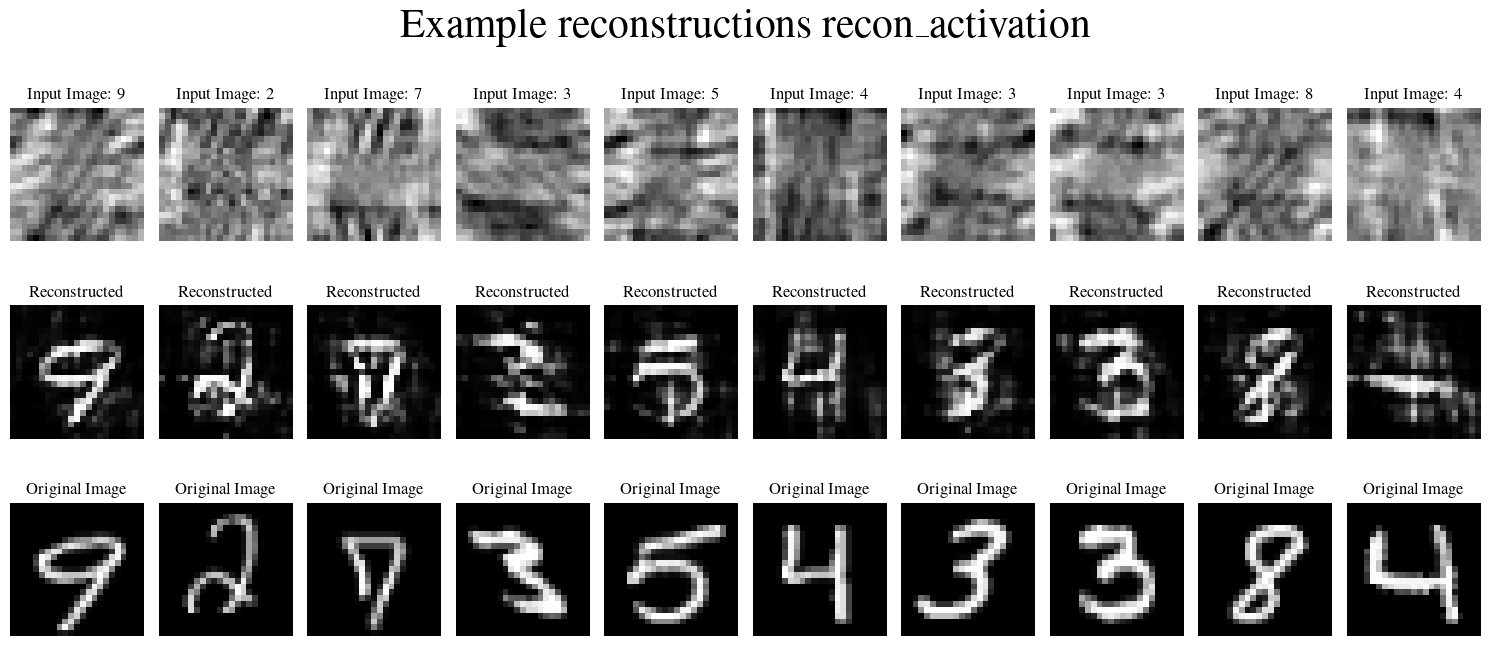

In [20]:
# Plotting reconstructed images
# Initializing subplot counter
counter = 1

# Plotting original images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['img']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title(f"Input Image: {test_outputs['digit'][idx]}")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1

# Plotting reconstructions
val = test_outputs['pred']#.numpy()
  
# Plotting first 10 images of the batch
for idx in range(10):
    plt.subplot(3, 10, counter)
    plt.title("Reconstructed")
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    #plt.colorbar()
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
# Plotting label images

# Plotting first 10 images
for idx in range(10):
    val = test_outputs['label']
    plt.subplot(3, 10, counter)
    plt.imshow(val[idx].reshape(model.img_size, model.img_size), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
  
    # Incrementing subplot counter
    counter += 1
    
plt.suptitle(f"Example reconstructions {params['model']}", fontsize=30)
#plt.savefig(path+f'figs/example_recons_{params["model"]}.png')
plt.tight_layout()
plt.show()

# Save Data

In [26]:
filename_train = "../data/training_MNIST_reconstructed"
filename_eval = "../data/validation_MNIST_reconstructed"
filename_test = "../data/testing_MNIST_reconstructed"

In [27]:
%%time

# Save encoded data 
torch.save(recon_train, filename_train)
torch.save(recon_eval, filename_eval)
torch.save(recon_test, filename_test)

CPU times: user 7.47 s, sys: 1.04 s, total: 8.51 s
Wall time: 8.69 s


In [29]:
recon_train_data = torch.load(filename_train)
recon_eval_data = torch.load(filename_eval)
recon_test_data = torch.load(filename_test)